In [22]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
from google.cloud import bigquery
from sklearn.metrics import mean_squared_error

In [9]:
import seaborn as sns

In [2]:
#connecting notebook to gcloud bigquery to query data.
cred_file = r"C:\Users\V0V01S7\AppData\Roaming\gcloud\legacy_credentials\venkatasaiyashaswi.v@walmart.com\adc.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_file
def query_bq(QUERY):
    client = bigquery.Client(project='wmt-edw-sandbox')
    query_job = client.query(QUERY) # API request
    rows = query_job.result() # Waits for query to finish
    df = rows.to_dataframe()
    return df

In [3]:
# choose driver name for forecasting later
code = """select A.DRVR_USER_ID, 
B.ACTV_START_TS, B.ACTL_ACTV_END_TS, B.ACTV_DUR_MIN_QTY, B.ACTV_DT, 
from `wmt-edw-prod.WW_GEC_VM.DRVR` A inner join `wmt-edw-prod.WW_GEC_VM.DRVR_APPLN_ACTV` B on A.DRVR_USER_ID = B.DRVR_USER_ID
where A.MARKET_NM = 'Walmart San Jose North' AND B.ACTV_NM = "ONLINE"
"""
df = query_bq(code)
df["ACTV_START_TS"] = pd.to_datetime(df["ACTV_START_TS"])
df["ACTL_ACTV_END_TS"] = pd.to_datetime(df["ACTL_ACTV_END_TS"])


iphoneskyper@gmail.com          654
glocesaga@hotmail.com           625
rodriguezriverajc@gmail.com     545
faisal4uzma@yahoo.com           486
vargasefrain.123@gmail.com      480
tleipelt@ymail.com              423
manuelsandoval1976@yahoo.com    402
eddielara90@yahoo.com           394
jim@stanley.net                 387
shaunjay2019@gmail.com          348
Name: DRVR_USER_ID, dtype: int64

In [4]:
df["DRVR_USER_ID"].value_counts().head(100)

iphoneskyper@gmail.com         654
glocesaga@hotmail.com          625
rodriguezriverajc@gmail.com    545
faisal4uzma@yahoo.com          486
vargasefrain.123@gmail.com     480
                              ... 
santosmehrara@yahoo.com         29
savinojalil2020@gmail.com       28
nickilovemc@gmail.com           28
brette.blostone@walmart.com     27
subernal_@hotmail.com           26
Name: DRVR_USER_ID, Length: 100, dtype: int64

In [5]:
def final_ft(df):
    df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
    time_line = time_line.to_series()
    ts = pd.DataFrame(time_line,columns = ["dayhour"])
    ts = ts.set_index("dayhour")
    ts = pd.merge(ts,df,how="left",on=["dayhour"])
    ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
    ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
    ts = ts.set_index(["dayhour"],drop=True)
    ts = ts.drop_duplicates()
    ts = ts.dropna()
    ts = ts.reset_index(drop=False)
    ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    def create_final_data(df):
        df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
        df = df[df['minutes']>0].reset_index(drop=True)
        # create an IntervalIndex which we can set as the axis (needed for re-indexing).
        # subtract one minute from end_time so that the minute of the termination is excluded.
        iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                              df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                              closed='both')
        # create a new index with the extended frequency:
        new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
        # set the new index to get the extended frequency;
        # all minutes will have the value of the whole interval
        result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
        # we can now calculate the duration per hour by resampling and summing the
        # boolean representation of the duration (1/0):
        result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
        result.index.name = 'start_hour'
        return result
    re = create_final_data(ts)
    re = pd.DataFrame(re)
    def create_features(df, label=None):
        """
        Creates time series features from datetime index.
        """
        df = df.copy()
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        if label:
            y = df[label]
            return X, y
        return X

    X, y = create_features(re, label='minutes')

    ft = pd.concat([X, y], axis=1)
    
    return ft

In [6]:
dfs = df.loc[df["DRVR_USER_ID"] == "santosmehrara@yahoo.com"]

In [7]:
ft = final_ft(dfs)
ft

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes
start_hour,,,,,,,,,
2022-05-09 12:00:00,12,0,2,5,2022,129,9,19,28
2022-05-09 13:00:00,13,0,2,5,2022,129,9,19,24
2022-05-09 14:00:00,14,0,2,5,2022,129,9,19,60
2022-05-09 15:00:00,15,0,2,5,2022,129,9,19,32
2022-05-09 16:00:00,16,0,2,5,2022,129,9,19,4
...,...,...,...,...,...,...,...,...,...
2022-06-24 16:00:00,16,4,2,6,2022,175,24,25,51
2022-06-24 17:00:00,17,4,2,6,2022,175,24,25,60
2022-06-24 18:00:00,18,4,2,6,2022,175,24,25,60


NameError: name 'final' is not defined

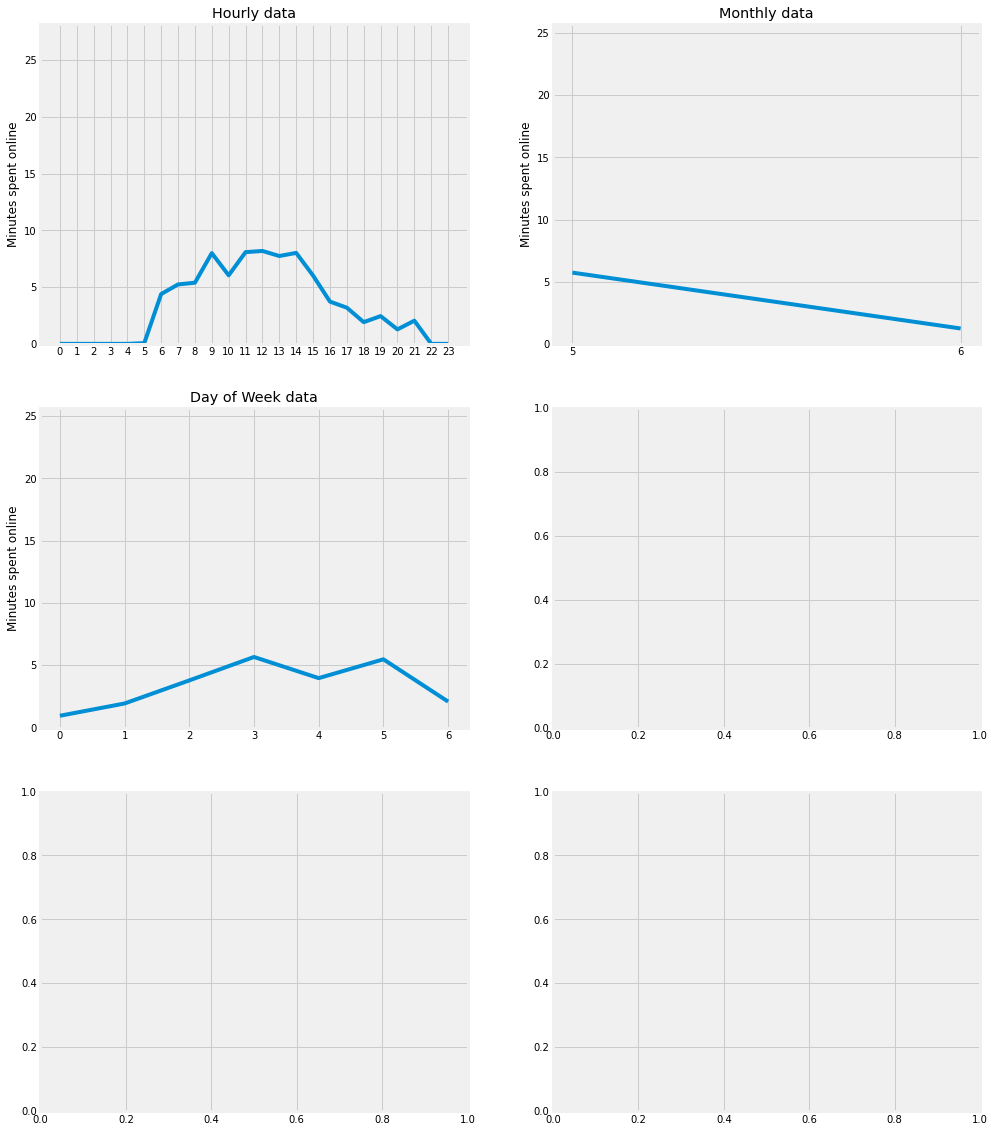

In [24]:
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(15,20))
ax1.plot(ft.groupby('hour')['minutes'].mean())
ax1.set_ylabel('Minutes spent online')
ax1.set_ylim([0, max(ft.groupby('hour')['minutes'].mean() + 20 )])
ax1.set_xticks(ft['hour'].unique())
ax1.set_title('Hourly data')

ax2.plot(ft.groupby('month')['minutes'].mean())
ax2.set_ylabel('Minutes spent online')
ax2.set_ylim([0, max(ft.groupby('month')['minutes'].mean() + 20 )])
ax2.set_xticks(ft['month'].unique())
ax2.set_title('Monthly data')

ax3.plot(ft.groupby('dayofweek')['minutes'].mean())
ax3.set_ylabel('Minutes spent online')
ax3.set_ylim([0, max(ft.groupby('dayofweek')['minutes'].mean() + 20 )])
ax3.set_xticks(ft['dayofweek'].unique())
ax3.set_title('Day of Week data')

sns.heatmap(final(dfb).sort_index(ascending = False), cmap='viridis', ax = ax4)
ax4.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

sns.distplot(ft['minutes'], kde=False, ax=ax5)
ax5.set_title('Number of minutes spent online distribution within 60 minutes')
ax5.set_xlabel('Minutes Spent')
ax5.set_ylabel('Number of times/count')

plt.show()

In [15]:
re = pd.DataFrame(ft.minutes)
re.tail()

,minutes
start_hour,
2022-06-24 16:00:00,51
2022-06-24 17:00:00,60
2022-06-24 18:00:00,60
2022-06-24 19:00:00,60
2022-06-24 20:00:00,0


In [12]:
re = re["2022-05-10 00:00:00":]

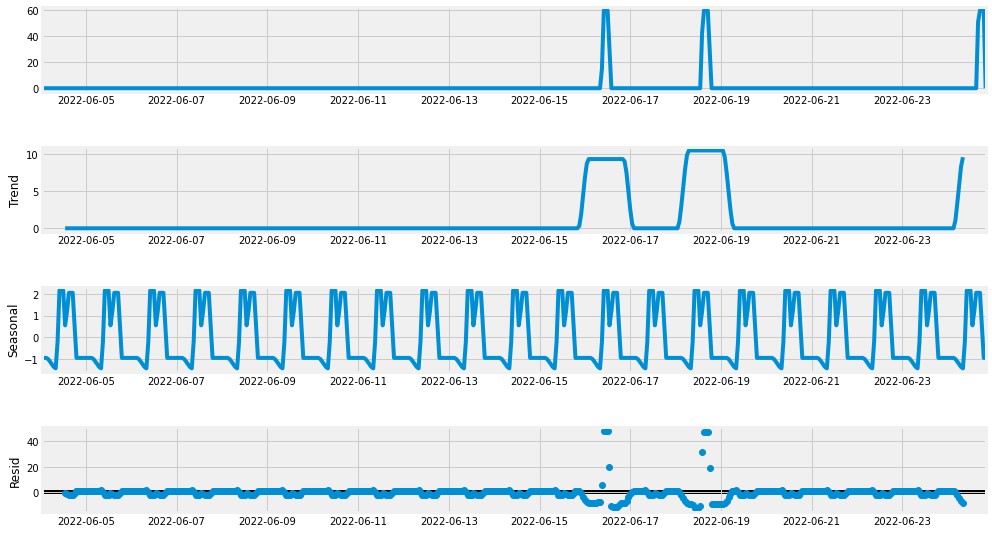

In [23]:
res = seasonal_decompose(re.tail(500))
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [16]:
split_date = '01-Jun-2022'
ts_train = re.loc[re.index <= split_date].copy()
ts_test = re.loc[re.index > split_date].copy()
tr_start,tr_end = ts_train.index[0],ts_train.index[-1]
te_start,te_end = ts_test.index[0],ts_test.index[-1]

In [27]:
calendar

pandas.tseries.holiday.USFederalHolidayCalendar